## The purpose of this script is to check charge throughput

In [1]:
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2
import pybamm as pb;import pandas as pd;import numpy as np;
import os, json,openpyxl,traceback,multiprocessing,scipy.optimize,sys
import matplotlib.pyplot as plt;
import imageio,timeit,random,time, signal
from scipy.io import savemat,loadmat;
from pybamm import constants,exp;import matplotlib as mpl

In [2]:
########################     Global settings!!!
rows_per_file = 3;  Scan_end_end = 12;
purpose_i = "SEI_Dry_Exp23_Paper_8"

On_HPC =  False  
Runshort  =   False                    # a long run or a quick test



if On_HPC:
    i_bundle = int(os.environ["PBS_ARRAY_INDEX"])
else:
    i_bundle = 1; # manually specify
Scan_start = (i_bundle-1)*rows_per_file+1;    
Scan_end   = min(Scan_start + rows_per_file-1, Scan_end_end)    
purpose = f"{purpose_i}_Case_{Scan_start}_{Scan_end}"
# interpetation: Simnon suggested, with cracking activation, heat transfer
para_csv = f"Bundle_{i_bundle}.csv"  # name of the random file to get parameters


if On_HPC:                          # Run on HPC
    Path_csv = f"InputData/{purpose_i}/" 
    Path_NiallDMA = "InputData/" 
    BasicPath=os.getcwd() 
    Para_file = Path_csv +  para_csv
else:
    import sys  
    str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
    str_path_1 = os.path.abspath(
        os.path.join(str_path_0,"wip/Rio_Code/Fun_P2"))
    sys.path.append(str_path_1) 
    Path_NiallDMA = os.path.expanduser(
        "~/EnvPBGEM_Linux/SimSave/InputData/") # for Linux
    BasicPath =  os.path.expanduser(
        "~/EnvPBGEM_Linux/SimSave/P2_R9_Dim")
    Para_file = BasicPath+f'/Get_Random_sets2/{purpose_i}/'+para_csv
    
if not os.path.exists(BasicPath +"/"+ purpose):
    os.mkdir(BasicPath +"/"+ purpose);
# import all functions 
from Fun_P2 import * 

# Load the random file
parameter_names, combinations = load_combinations_from_csv(Para_file)


pool_no = len(combinations)
Indexs  = np.arange(Scan_start-1,Scan_end)
index_list = Indexs+1
""" para_dict_Same = {
   "Total ageing cycles":int(tot_cyc), # 
   "Ageing cycles between RPT":int(cyc_age), # 
   "Update cycles for ageing": int(cyc_age),
} """
# Get all para
Para_dict_list = []
# get all dictionaries
for combination in combinations:
    input_dict = {}
    for parameter_name,para_value in zip(parameter_names,combination ):
        input_dict[parameter_name] = para_value
    Para_dict_list.append(input_dict)
print(f"Total scan case is {len(Para_dict_list)}")

Total scan case is 3


In [3]:
# define global index and dict for all experiment data - prepare for read!
Exp_Path = [
    "Expt 1 - Si-based Degradation/",
    "Expt 2,2 - C-based Degradation 2/",
    "Expt 3 - Cathode Degradation and Li-Plating/",
    "Expt 4 - Drive Cycle Aging (Control)/",
    "Expt 5 - Standard Cycle Aging (Control)/",]
Exp_head = [
    "Expt 1",
    "Expt 2,2",
    "Expt 3",
    "Expt 4",
    "Expt 5",]
Exp_1_Cell = ["A","B","J","D","E","F","K","L","M"];
Exp_1_Temp = {
    "A":"10","B":"10","J":"10",
    "D":"25","E":"25","F":"25",
    "K":"40","L":"40","M":"40",}
Temp_Cell_Exp_1 = {
    "10":["A","B","J"],
    "25":["D","E","F"],
    "40":["K","L","M"],}
Exp_2_Cell = ["A","B","C","D","E","F"];
Exp_2_Temp = {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",}
Temp_Cell_Exp_2 = {
    "10":["A","B"],
    "25":["C","D"],
    "40":["E","F"],}
Exp_3_Cell = ["A","B","C","D","E","F","G","H","I"];
Exp_3_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25","F":"25",
    "G":"40","H":"40","I":"40"}
Temp_Cell_Exp_3 = {
    "10":["A","B","C"],
    "25":["D","E","F"],
    "40":["G","H","I"],}
Exp_4_Cell = ["A","B","C","D","E","F","G","H"];
Exp_4_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_4 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_5_Cell = ["A","B","C","D","E","F","G","H"];
Exp_5_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_5 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_All_Cell  = [Exp_1_Cell,Exp_2_Cell,Exp_3_Cell,Exp_4_Cell,Exp_5_Cell]
Exp_Temp_Cell = [Exp_1_Temp,Exp_2_Temp,Exp_3_Temp,Exp_4_Temp,Exp_5_Temp]
Temp_Cell_Exp_All = [Temp_Cell_Exp_1,Temp_Cell_Exp_2,Temp_Cell_Exp_3,Temp_Cell_Exp_4,Temp_Cell_Exp_5]
Mark_Cell_All = [
    {
    "A":"o","B":">","J":"v",
    "D":"o","E":">","F":"v",
    "K":"o","L":">","M":"v",},
    {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">","F":"v",
    "G":"o","H":">","I":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",}]
Color_Cell_All = [
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"J":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "K":[1,0,0,0.4],"L":[1,0,0,0.4],"M":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"C":[0, 0, 0,0.7],
    "E":[1,0,0,0.4],"F":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "G":[1,0,0,0.4],"H":[1,0,0,0.4],"I":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],}]
# Update 23-06-17 
#   para="Total heat transfer coefficient [W.m-2.K-1]";
#   output="Volume-averaged cell temperature [C]"
########################  Output  ########################
keys_loc_RPT = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    #"CCend Negative electrode roughness ratio",
    #"CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"CDend Negative electrode roughness ratio",
    #"CDend Total SEI on cracks thickness [m]",
    #"REend Total SEI on cracks thickness [m]",
]
keys_tim_RPT = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    "CD Anode potential [V]",    # self defined
    "CD Cathode potential [V]",  # self defined
    "CC Time [h]",
    "CC Terminal voltage [V]",
    "CC Anode potential [V]",    # self defined
    "CC Cathode potential [V]",  # self defined
]
keys_cyc_RPT = [   # default: CDend
    "Discharge capacity [A.h]",
    "Throughput capacity [A.h]",
    "CDend Total lithium capacity in particles [A.h]",
    "CDend Loss of capacity to lithium plating [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CDend Loss of capacity to SEI on cracks [A.h]",
    #"CDend X-averaged total SEI on cracks thickness [m]",
    #"CDend X-averaged negative electrode roughness ratio",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode stoichiometry", 
    "CDend Negative electrode stoichiometry",
    "CDsta Positive electrode stoichiometry", 
    "CDend Positive electrode stoichiometry",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
]

keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    "CCend Negative electrode surface potential difference [V]",
    "CCend SEI film overpotential [V]",
    #"CCend Negative electrode roughness ratio",
    #"CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"CDend Negative electrode roughness ratio",
    #"CDend Total SEI on cracks thickness [m]",
    "CDend Negative electrode surface potential difference [V]",
    "CDend SEI film overpotential [V]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
]
keys_tim_AGE = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    "CD Anode potential [V]",    # self defined
    "CD Cathode potential [V]",  # self defined
    
    "CC Time [h]",
    "CC Terminal voltage [V]",
    "CC Anode potential [V]",    # self defined
    "CC Cathode potential [V]",  # self defined
]
keys_cyc_AGE = [];
keys_all_RPT = [keys_loc_RPT,keys_tim_RPT,keys_cyc_RPT];
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];
keys_all = [keys_all_RPT,keys_all_AGE];


# Write para - 1st round:
Values_1 = []
head_keys = list(Para_dict_list[0].keys())
head_pre = [
    "Scan No","Exp No.","Y or N",
    "Error Tot%","Error SOH %","Error LLI %",
    "Error LAM NE %","Error LAM PE %",
    "Error Res %","Error ageT %","Punish",
    "Dry out",]

head_pos = [ 
    "Total ageing cycles","Ageing cycles between RPT",
    "Update cycles for ageing",
    "exp_AGE_text", "exp_RPT_text",
   "Cap Loss","LLI to LiP",
   "LLI to SEI","LLI to sei-on-cracks",
   "LAM to Neg","LAM to Pos",
   "Vol_Elely_Tot Final", "Vol_Elely_JR Final","Width Final","Error"]
Values_1 .append([*head_pre,*head_keys,*head_pos])
book_name_xlsx = f'Summary_{purpose}.xlsx';
sheet_name_xlsx = 'Output'
Target  = f'/{purpose}/'
write_excel_xlsx(
    BasicPath + Target + book_name_xlsx, 
    sheet_name_xlsx, Values_1)   
Exp_pack = [
    Exp_All_Cell,Temp_Cell_Exp_All,
    Exp_Path,Exp_head,Exp_Temp_Cell,
    book_name_xlsx,]  
# remaining set-up for experiment and create folders

if not os.path.exists(BasicPath +Target+"Mats"):
    os.mkdir(BasicPath +Target +"Mats");
if not os.path.exists(BasicPath +Target+"Plots"):
    os.mkdir(BasicPath +Target+"Plots");
if not os.path.exists(BasicPath +Target+"Excel"):
    os.mkdir(BasicPath +Target+"Excel");

Successfully create a excel file


In [4]:
Para_dict_list[0]['Mesh list'] = '[5,5,5,60,20]'

In [5]:
Para_dict_list[0]

{'Scan No': 1,
 'Exp No.': 2,
 'Ageing temperature': 10.0,
 'Mesh list': '[5,5,5,60,20]',
 'Inner SEI lithium interstitial diffusivity [m2.s-1]': 1.6e-18,
 'Dead lithium decay constant [s-1]': 1e-06,
 'Lithium plating kinetic rate constant [m.s-1]': 1e-09,
 'Negative electrode LAM constant proportional term [s-1]': 3e-07,
 'Positive electrode LAM constant proportional term [s-1]': 3e-07,
 'Negative electrode cracking rate': 1e-20,
 'Outer SEI partial molar volume [m3.mol-1]': 6.74e-05,
 'SEI growth activation energy [J.mol-1]': 420.0,
 'Negative cracking growth activation energy [J.mol-1]': 0.0,
 'Negative electrode diffusivity activation energy [J.mol-1]': 17000.0,
 'Positive electrode diffusivity activation energy [J.mol-1]': 12000.0,
 'Contact resistance [Ohm]': 0.0115,
 'Total heat transfer coefficient [W.m-2.K-1]': 20,
 'Initial electrolyte excessive amount ratio': 1.0,
 'Cycles within RPT': 1,
 'RPT temperature': 25,
 'Para_Set': 'OKane2023',
 'Model option': "{'SEI': 'interstiti

In [7]:
fs = 13; dpi = 100;
midc_merge_all = [];Sol_RPT_all = [];Sol_AGE_all = [];
Plot_Exp=True;     Timeout=False;  
Return_Sol=True;   Check_Small_Time=True; R_from_GITT = False
Runshort = False
midc_merge,Sol_RPT,Sol_AGE = Run_P2_Excel (
    Para_dict_list[0],BasicPath, Path_NiallDMA, 
    purpose,    Exp_pack, keys_all,dpi,fs,
    Runshort,   Plot_Exp,Timeout,Return_Sol,
    Check_Small_Time, R_from_GITT
) 


Start Now! Scan 1.
Read Exp-2 - Cell A RPT 0
Read Exp-2 - Cell A RPT 1
Read Exp-2 - Cell A RPT 2
Read Exp-2 - Cell A RPT 3
Read Exp-2 - Cell A RPT 4
Read Exp-2 - Cell A RPT 5
Read Exp-2 - Cell A RPT 6
Read Exp-2 - Cell A RPT 7
Read Exp-2 - Cell A RPT 8
Read Exp-2 - Cell A RPT 9
Read Exp-2 - Cell A RPT 10
Read Exp-2 - Cell A RPT 11
Read Exp-2 - Cell A RPT 12
Exp-2 - Cell A doesn't have RPT 13
Exp-2 - Cell A doesn't have RPT 14
Exp-2 - Cell A doesn't have RPT 15
Read Exp-2 - Cell B RPT 0
Read Exp-2 - Cell B RPT 1
Read Exp-2 - Cell B RPT 2
Read Exp-2 - Cell B RPT 3
Read Exp-2 - Cell B RPT 4
Read Exp-2 - Cell B RPT 5
Read Exp-2 - Cell B RPT 6
Read Exp-2 - Cell B RPT 7
Read Exp-2 - Cell B RPT 8
Read Exp-2 - Cell B RPT 9
Read Exp-2 - Cell B RPT 10
Read Exp-2 - Cell B RPT 11
Read Exp-2 - Cell B RPT 12
Exp-2 - Cell B doesn't have RPT 13
Exp-2 - Cell B doesn't have RPT 14
Exp-2 - Cell B doesn't have RPT 15
Read Exp-2 - Cell C RPT 0
Read Exp-2 - Cell C RPT 1
Read Exp-2 - Cell C RPT 2
Read Exp-2 

At t = 242.785, , mxstep steps taken before reaching tout.
At t = 242.785, , mxstep steps taken before reaching tout.
At t = 92.7845 and h = 2.92052e-14, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.516 RPT cycles within 1 minute, 13 seconds
Scan 1: Finish post-process for No.516 RPT cycles within 801.639 ms
Scan 1: Finish for No.516 ageing cycles within 14 minutes, 59 seconds
Scan 1: Finish post-process for No.1032 ageing cycles within 76.072 ms


At t = 139.759, , mxstep steps taken before reaching tout.
At t = 139.759, , mxstep steps taken before reaching tout.
At t = 139.759, , mxstep steps taken before reaching tout.


Scan 1: Finish for No.1032 RPT cycles within 4 minutes, 4 seconds
Scan 1: Finish post-process for No.1032 RPT cycles within 817.009 ms
Scan 1: Getting extra variables within 158.700 us
Scan 1: Finish all plots within 6.828 s
Successfully create a excel file
Scan 1: Successfully save json file!
Scan 1: Successfully save mat file!
Scan 1: Try saving within 32.581 ms
Succeed doing something in 36 minutes, 59 seconds
This is the end of No. 1  scan


In [ ]:
midc_merge["Discharge capacity [A.h]"]

[4.866396253792297, 4.856686120195983, 4.851598246464969]

In [9]:
np.array(midc_merge['Throughput capacity [kA.h]'])*1e3

array([  19.13582945, 1097.28925147, 2175.15800363])

1.2655984404456246 1.2655984404456255
1.459463652645032 1.459463652644942
703.0660200173893


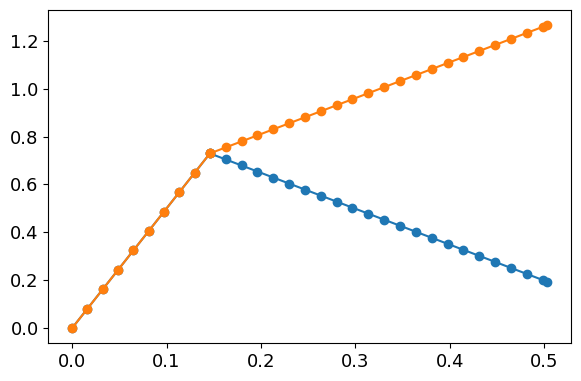

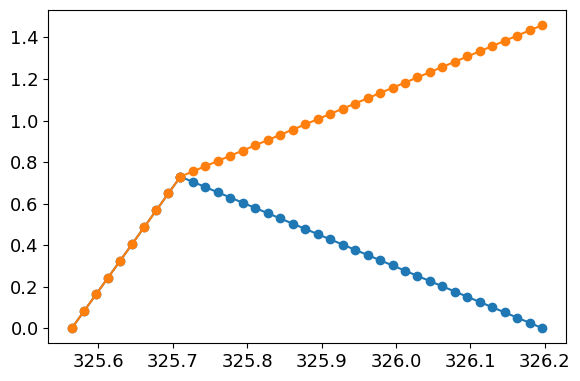

In [14]:

thr_cap_1,thr_cap_2 = Plot_sol(Sol_AGE[0].cycles[0])
thr_cap_3,thr_cap_4 = Plot_sol(Sol_AGE[0].cycles[-1])
print((thr_cap_1+thr_cap_3)/2*516)

[  0.38080502   0.39758058   0.41435613   0.43113168   0.44790723
   0.46468278   0.48145833   0.49823389   0.50318859 325.56432987
 325.58054624 325.59676261]


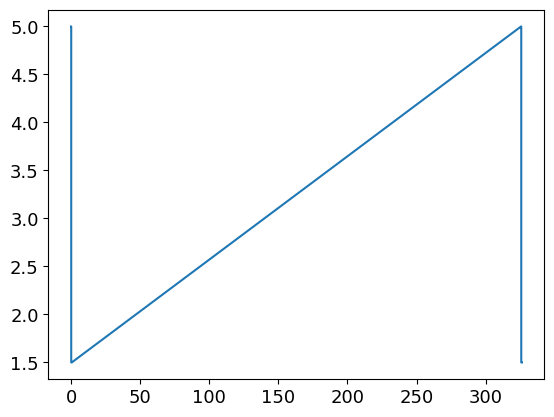

In [18]:
plt.plot(Sol_AGE[0]["Time [h]"].entries,abs(Sol_AGE[0]["Current [A]"].entries), )
print(Sol_AGE[0]["Time [h]"].entries[24:36])

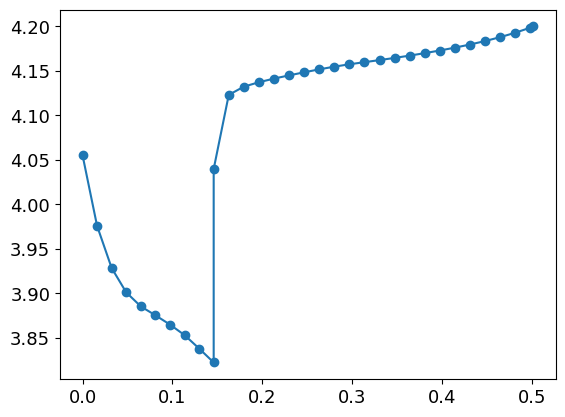

In [ ]:
plt.plot(Sol_AGE[1]["Time [h]"].entries,Sol_AGE[0]["Terminal voltage [V]"].entries,'-o')

In [ ]:
(0.7297365+0.5339990778626663)*516
0.7297365*2*518
print(len(Sol_AGE),len(Sol_RPT),)

2 3


1059.1737712474505 1059.1737712474512
1059.1664501759062 1059.1664501759067
19.13582944640948 19.135829446409392
18.97965077554204 18.97965077554207
18.70230198438321 18.702301984382974
2175.1580036296914


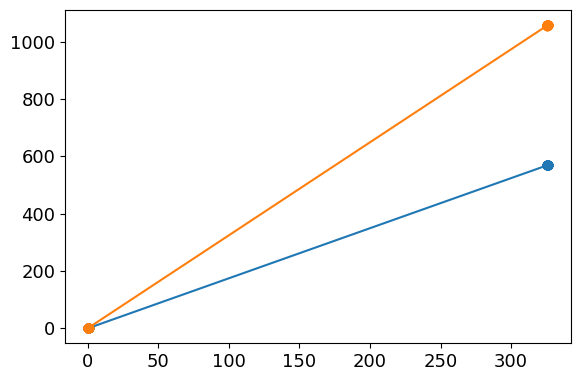

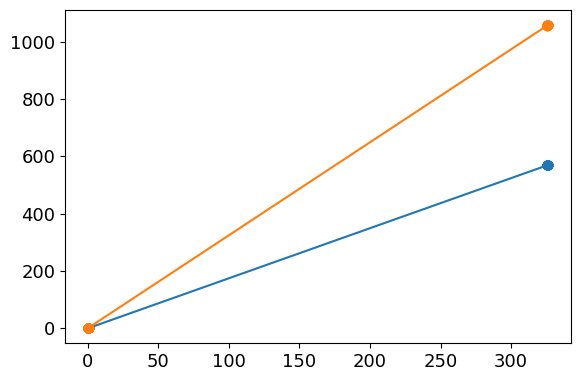

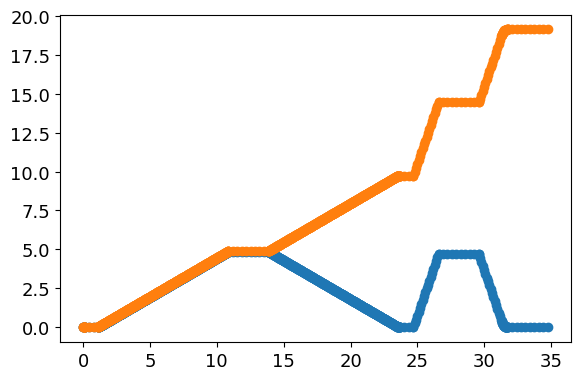

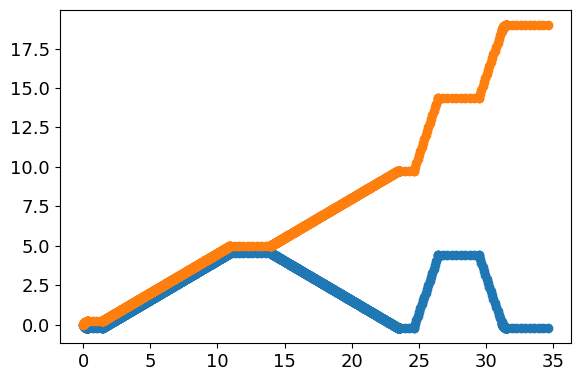

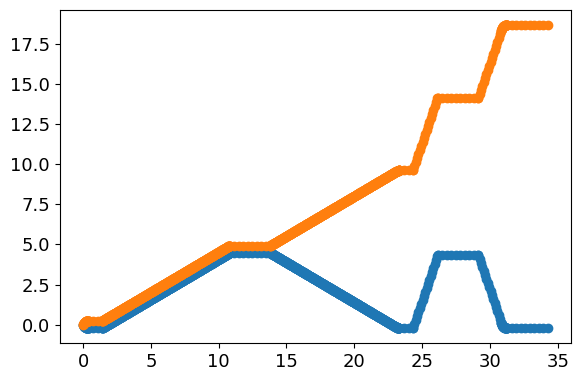

In [8]:
def Plot_sol(sol):
    # step-1: get and plot discharge capacity vs throughput capacity 
    fig, axs = plt.subplots( figsize=(6,4),tight_layout=True) 
    axs.plot(sol["Time [h]"].entries,sol["Discharge capacity [A.h]"].entries,'-o')
    axs.plot(sol["Time [h]"].entries,sol["Throughput capacity [A.h]"].entries-sol["Throughput capacity [A.h]"].entries[0],'-o')
    thr_cap_1 = sol["Throughput capacity [A.h]"].entries[-1]-sol["Throughput capacity [A.h]"].entries[0]
    thr_cap_2 = np.trapz(abs(sol["Current [A]"].entries), sol["Time [h]"].entries) # in A.h
    print(thr_cap_1,thr_cap_2)
    return thr_cap_1,thr_cap_2
cap_acc = 0
for i in range(2):
    thr_cap_1,thr_cap_2 = Plot_sol(Sol_AGE[i])
    cap_acc +=  thr_cap_1
for i in range(3):
    thr_cap_1,thr_cap_2 = Plot_sol(Sol_RPT[i])
    cap_acc +=  thr_cap_1
print(cap_acc)

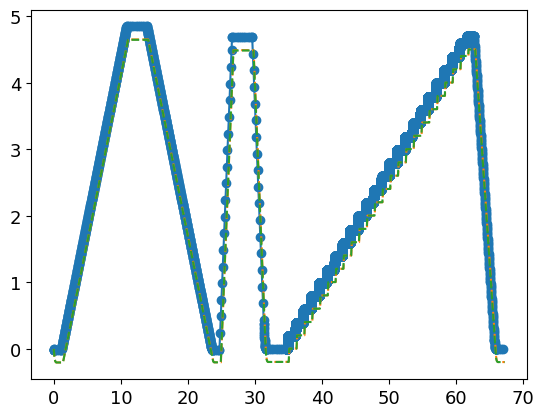

In [ ]:
plt.plot(Sol_RPT[0]["Time [h]"].entries,Sol_RPT[0]["Discharge capacity [A.h]"].entries,'-o')
plt.plot(Sol_RPT[1]["Time [h]"].entries,Sol_RPT[1]["Discharge capacity [A.h]"].entries,'--')
plt.plot(Sol_RPT[2]["Time [h]"].entries,Sol_RPT[2]["Discharge capacity [A.h]"].entries,'--')

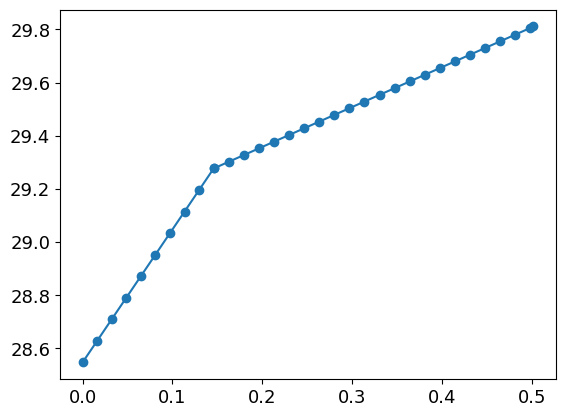

In [ ]:
plt.plot(Sol_AGE[1]["Time [h]"].entries,Sol_AGE[0]["Throughput capacity [A.h]"].entries,'-o')

In [ ]:
# Sol_0[0].cycles[-1]["Negative electrode stoichiometry"].entries
#label = ["Diff_Li_SEI = 1e-18","Diff_Li_SEI = 1e-16"] 
vars = [
    "Negative electrode stoichiometry",
    "Positive electrode stoichiometry",
    "SEI interfacial current density [A.m-2]",
    "Negative particle surface concentration [mol.m-3]",
    
]
quick_plot = pb.QuickPlot(
    Sol_0[0].cycles[-1], 
    vars,variable_limits='tight') #     
quick_plot.dynamic_plot();

In [ ]:
Sol_0[-2].cycles

In [ ]:
vars = [
    "Negative electrode stoichiometry",
    "Positive electrode stoichiometry",
    "SEI interfacial current density [A.m-2]",
    "Negative particle surface concentration [mol.m-3]",
    
]
quick_plot = pb.QuickPlot(
    Sol_0[-1].cycles[0], 
    vars,variable_limits='tight') #     
quick_plot.dynamic_plot();